In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image 

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    # display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
pd.options.display.max_colwidth = 100
pd.set_option('display.max_columns', 500)


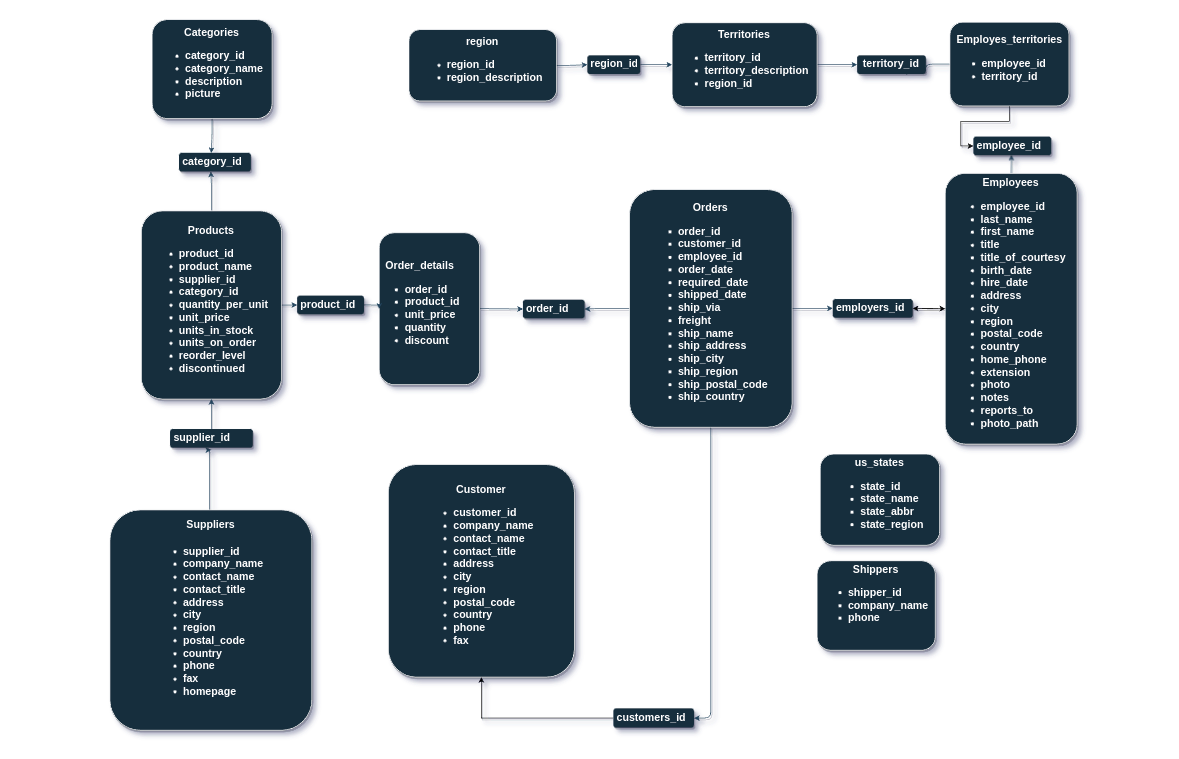

In [6]:
mer = Image(filename='img/mer.png')
display(mer)

In [7]:
orders = pd.read_csv('data/orders.csv', sep=';')
order_details = pd.read_csv('data/order_details.csv', sep=';')
products = pd.read_csv('data/products.csv', sep=';')
categories = pd.read_csv('data/categories.csv', sep=';')
customer_customer_demo = pd.read_csv('data/customer_customer_demo.csv', sep=';')
customer_demographics = pd.read_csv('data/customer_demographics.csv', sep=';')
customers = pd.read_csv('data/customers.csv', sep=';')
employee_territories = pd.read_csv('data/employee_territories.csv', sep=';')
employees = pd.read_csv('data/employees.csv', sep=';')
region = pd.read_csv('data/region.csv', sep=';')
shippers = pd.read_csv('data/shippers.csv', sep=';')
suppliers = pd.read_csv('data/suppliers.csv', sep=';')
territories = pd.read_csv('data/territories.csv', sep=';')
us_states = pd.read_csv('data/us_states.csv', sep=';')

### ORDER

| column | meaning |
| --- | --- |
| order_id | unique identification per order |
| customer_id | unique identification per customer |
| employee_id | unique identification per employee |
| order_date | order date |
| required_date | date by which your customer needs the product. |
| shipped_date | shipped date |
| ship_via | ship via (number) |
| freight | freight |
| ship_name | ship name |
| ship_address | ship address |
| ship_city | ship city |
| ship_region | ship region |
| ship_postal_code | ship postal code |
| ship_country | ship country |

### Create a churn period

In [8]:
orders['order_date'] = pd.to_datetime(orders['order_date'])
orders['required_date'] = pd.to_datetime(orders['required_date'])
orders['shipped_date'] = pd.to_datetime(orders['shipped_date'])

In [9]:
# This date is the most recent one, so let's assume this date is today because we need to calculate  the churn 
today = orders.order_date.max()

In [10]:
# get the last purchase date
customer_date = orders.groupby('customer_id')[['order_date']].max().reset_index()
customer_date = customer_date.rename(columns = {'order_date': 'last_purchase'})

# get the first purchase date
customer_date['first_purchase'] = orders.groupby('customer_id')[['order_date']].min().reset_index().order_date.copy()

# calculate the lifetime of customers
customer_date['customer_lifetime'] = (customer_date.last_purchase - customer_date.first_purchase).dt.days

# get the number of purchases
customer_date['number_of_purchase'] = orders.groupby('customer_id')[['order_id']].nunique().reset_index().order_id.copy()

# calculate the average time in days between purchases
customer_date['average_time_between_purchase'] = ((customer_date.customer_lifetime) / customer_date.number_of_purchase).astype(int)

# calculate the time to the last purchase
customer_date['time_to_last_purchase'] = (today - customer_date.last_purchase).dt.days

In [11]:
np.round(customer_date.describe().T,0)

count   mean    std  min    25%    50%    75%    max
customer_lifetime               89.0  490.0  152.0  0.0  427.0  530.0  602.0  663.0
number_of_purchase              89.0    9.0    6.0  1.0    5.0    8.0   12.0   31.0
average_time_between_purchase   89.0   65.0   37.0  0.0   40.0   58.0   79.0  253.0
time_to_last_purchase           89.0   52.0   87.0  0.0    8.0   23.0   58.0  657.0

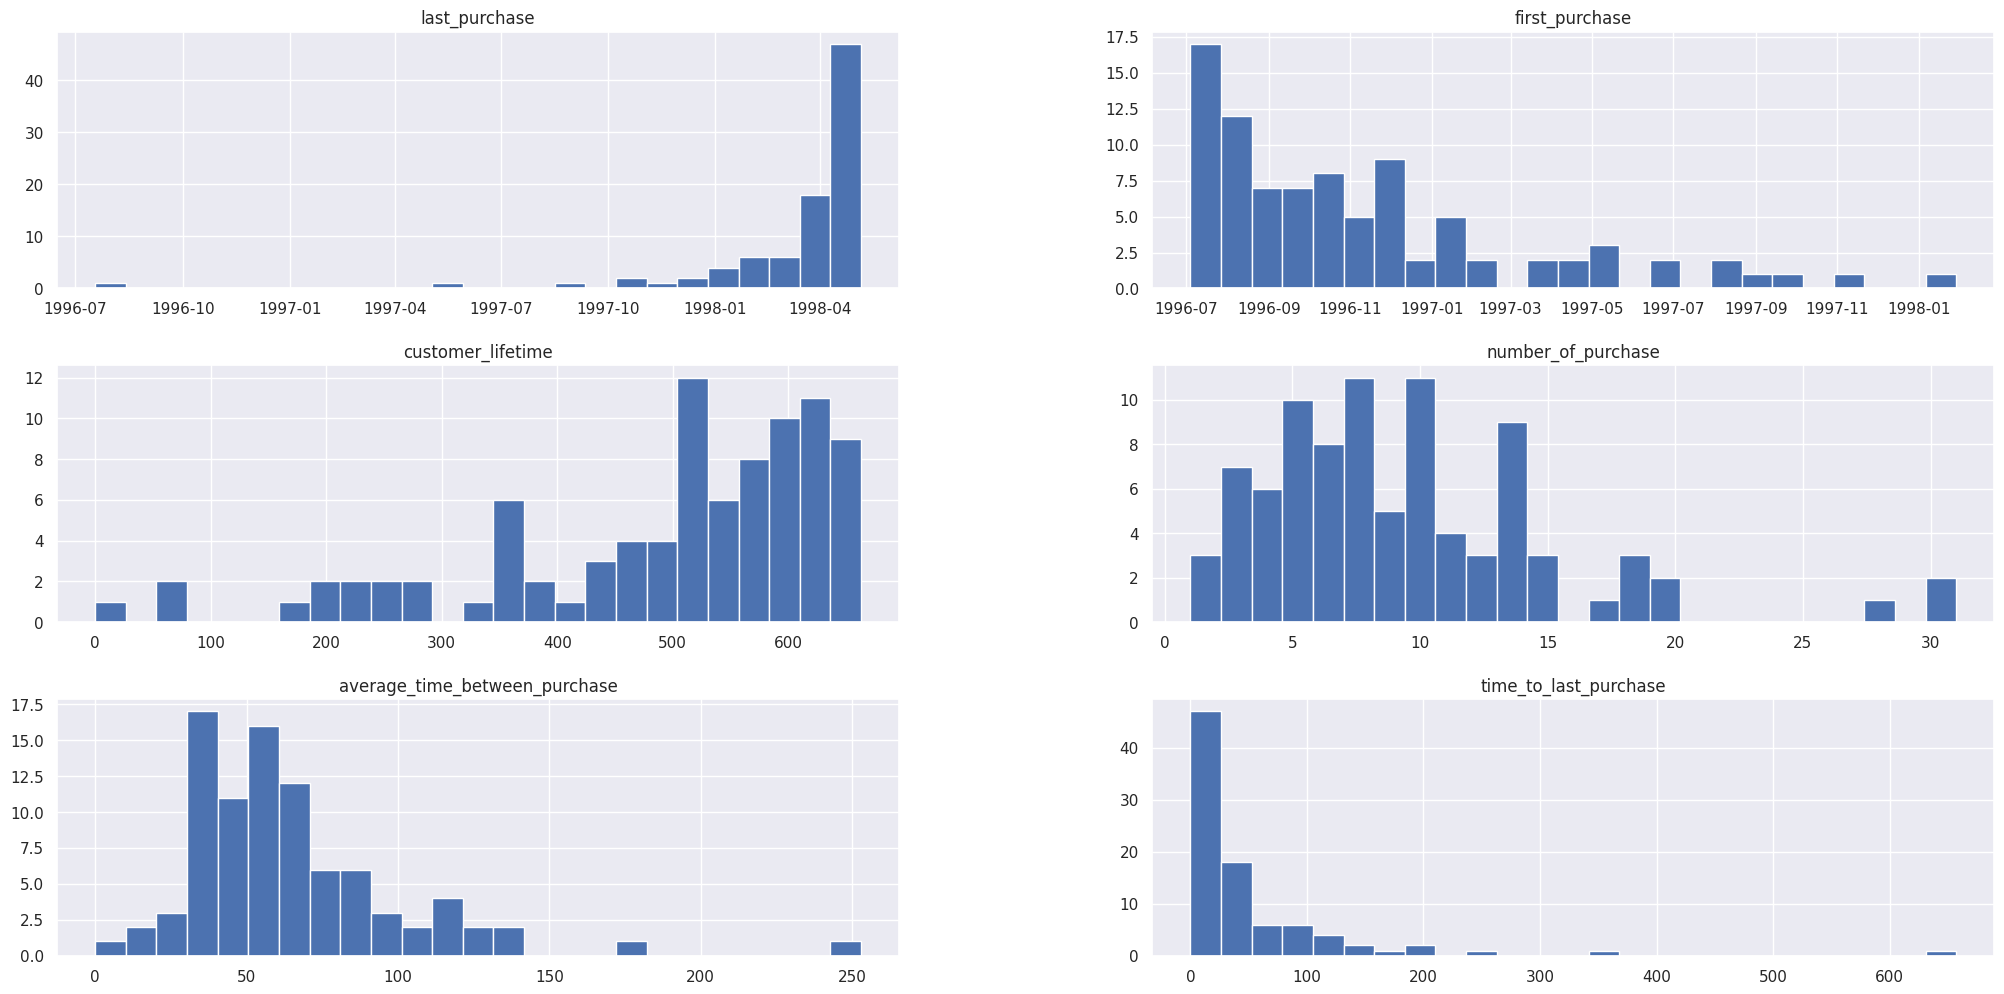

In [12]:
customer_date.hist(bins=25);

# Churn Rate

### Based on the analysis above, the churn period is set to 70 days, as after 70 days the average time between purchases drop

In [13]:
customer_date['churn'] = customer_date.time_to_last_purchase > 70

# Churn Analysis

### H1 - The churn rate over the customer's lifetime is increasing
False - Customer lifetime churn rate is decreasing. 

That's a good sign because if a customer's lifetime churn rate is increasing, it could mean the products aren't good.

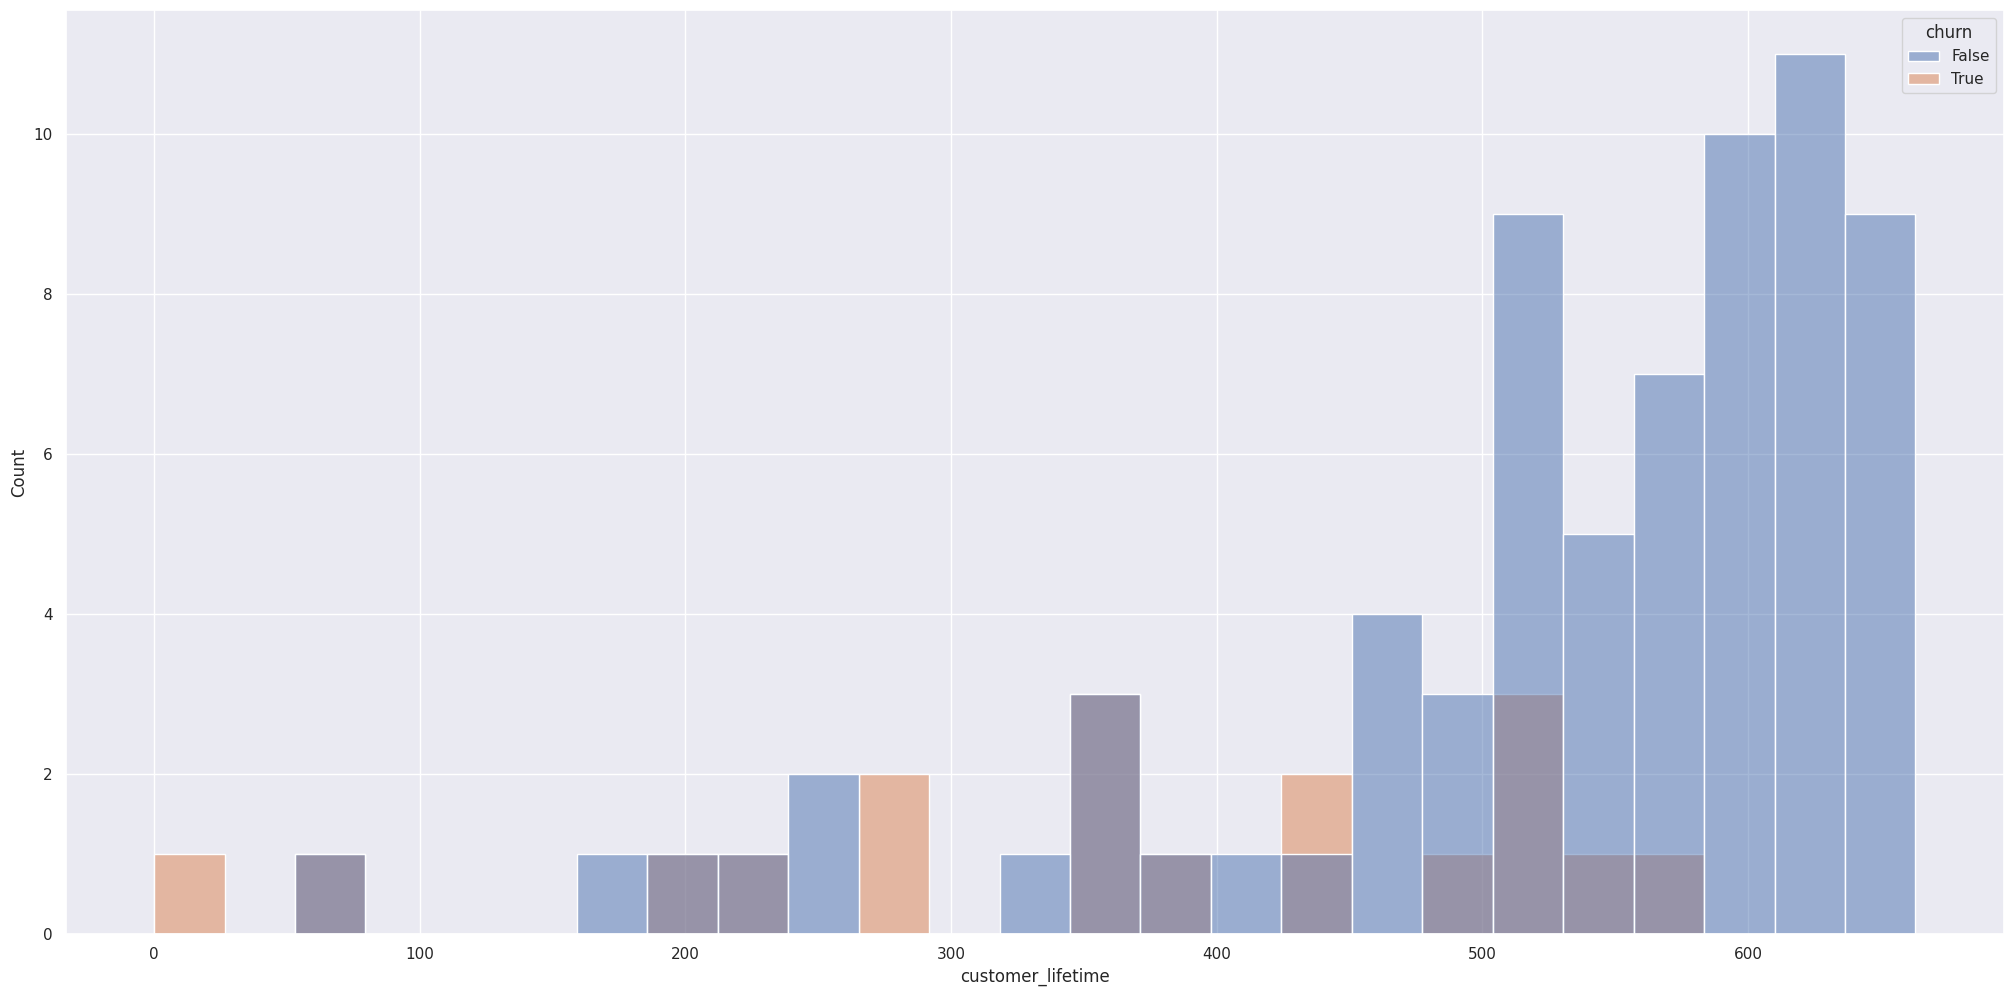

In [14]:
aux = customer_date.copy()
aux = aux.sort_values('customer_lifetime')

sns.histplot( data=aux, x='customer_lifetime', hue='churn', fill=True,common_norm=False, bins=25);

### H2 - The churn rate is 30%
False - The churn rate is 20.22%

In [15]:
print(f'The churn rate is {np.round(aux.churn.mean()*100,2)}%')

The churn rate is 20.22%


### H3 - USA is the country with the most churn
False - France is the country with the most churn, with a 50% churn rate

In [16]:
data = customer_date.merge(customers, on='customer_id', how='inner')

In [17]:
aux = data.groupby('country')[['churn']].sum().reset_index().copy()
aux['customers_per_country'] = data.groupby('country')[['churn']].count().reset_index().copy().churn
aux['churnrate'] = np.round(aux.churn/aux.customers_per_country*100)
aux = aux.sort_values('churn',ascending=False)

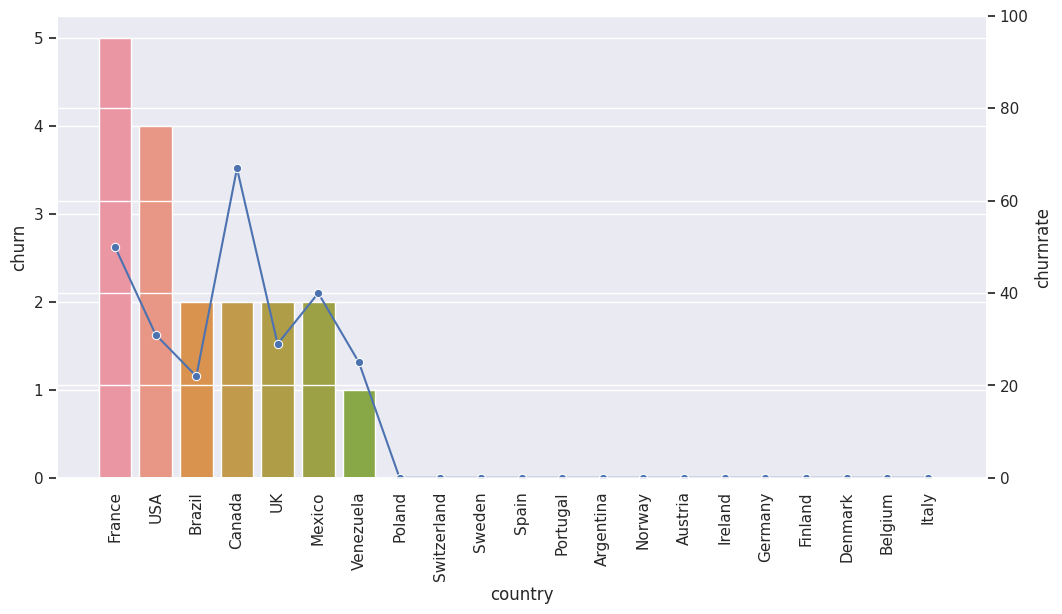

In [18]:
fig, ax1 = plt.subplots(figsize=(12,6))

sns.barplot(data = aux, x='country', y='churn', alpha=1, ax=ax1)
plt.xticks(rotation=90);

ax2 = ax1.twinx()

sns.lineplot(data = aux, x='country', y='churnrate', marker='o', sort = False, ax=ax2)
plt.ylim(0, 100)
plt.xticks(rotation=90);

In [19]:
data.head()

customer_id last_purchase first_purchase  customer_lifetime  number_of_purchase  average_time_between_purchase  time_to_last_purchase  churn                        company_name        contact_name         contact_title                        address         city region postal_code  country           phone             fax
0       ALFKI    1998-04-09     1997-08-25                227                   6                             37                     27  False                 Alfreds Futterkiste        Maria Anders  Sales Representative                  Obere Str. 57       Berlin    NaN       12209  Germany     030-0074321     030-0076545
1       ANATR    1998-03-04     1996-09-18                532                   4                            133                     63  False  Ana Trujillo Emparedados y helados        Ana Trujillo                 Owner  Avda. de la Constitución 2222  México D.F.    NaN       05021   Mexico    (5) 555-4729    (5) 555-3745
2       ANTON    1998-01-28     1996-11-27                427                   7                             61                     98   True             Antonio Moreno Taquería      Antonio Moreno                 Owner                Mataderos  2312  México D.F.    NaN       05023   Mexico    (5) 555-3932             NaN
3       AROUT    1998-04-10     1996-11-15                511                  13                             39                     26  False                     Around the Horn        Thomas Hardy  Sales Representative                120 Hanover Sq.       London    NaN     WA1 1DP       UK  (171) 555-7788  (171) 555-6750
4       BERGS    1998-03-04     1996-08-12                569                  18                             31                     63  False                  Berglunds snabbköp  Christina Berglund   Order Administrator                Berguvsvägen  8        Luleå    NaN    S-958 22   Sweden   0921-12 34 65   0921-12 34 67

### ORDERS

In [24]:
orders = orders.merge(order_details, on='order_id', how='inner')
orders

order_id customer_id  employee_id order_date required_date shipped_date  ship_via  freight                           ship_name                                    ship_address        ship_city    ship_region ship_postal_code ship_country  product_id_x  unit_price_x  quantity_x  discount_x  product_id_y  unit_price_y  quantity_y  discount_y
0        10248       VINET            5 1996-07-04    1996-08-01   1996-07-16         3    32.38           Vins et alcools Chevalier                              59 rue de l'Abbaye            Reims            NaN            51100       France            11         14.00          12        0.00            11         14.00          12        0.00
1        10248       VINET            5 1996-07-04    1996-08-01   1996-07-16         3    32.38           Vins et alcools Chevalier                              59 rue de l'Abbaye            Reims            NaN            51100       France            11         14.00          12        0.00            42          9.80          10        0.00
2        10248       VINET            5 1996-07-04    1996-08-01   1996-07-16         3    32.38           Vins et alcools Chevalier                              59 rue de l'Abbaye            Reims            NaN            51100       France            11         14.00          12        0.00            72         34.80           5        0.00
3        10248       VINET            5 1996-07-04    1996-08-01   1996-07-16         3    32.38           Vins et alcools Chevalier                              59 rue de l'Abbaye            Reims            NaN            51100       France            42          9.80          10        0.00            11         14.00          12        0.00
4        10248       VINET            5 1996-07-04    1996-08-01   1996-07-16         3    32.38           Vins et alcools Chevalier                              59 rue de l'Abbaye            Reims            NaN            51100       France            42          9.80          10        0.00            42          9.80          10        0.00
5        10248       VINET            5 1996-07-04    1996-08-01   1996-07-16         3    32.38           Vins et alcools Chevalier                              59 rue de l'Abbaye            Reims            NaN            51100       France            42          9.80          10        0.00            72         34.80           5        0.00
6        10248       VINET            5 1996-07-04    1996-08-01   1996-07-16         3    32.38           Vins et alcools Chevalier                              59 rue de l'Abbaye            Reims            NaN            51100       France            72         34.80           5        0.00            11         14.00          12        0.00
7        10248       VINET            5 1996-07-04    1996-08-01   1996-07-16         3    32.38           Vins et alcools Chevalier                              59 rue de l'Abbaye            Reims            NaN            51100       France            72         34.80           5        0.00            42          9.80          10        0.00
8        10248       VINET            5 1996-07-04    1996-08-01   1996-07-16         3    32.38           Vins et alcools Chevalier                              59 rue de l'Abbaye            Reims            NaN            51100       France            72         34.80           5        0.00            72         34.80           5        0.00
9        10249       TOMSP            6 1996-07-05    1996-08-16   1996-07-10         1    11.61                  Toms Spezialitäten                                   Luisenstr. 48          Münster            NaN            44087      Germany            14         18.60           9        0.00            14         18.60           9        0.00
10       10249       TOMSP            6 1996-07-05    1996-08-16   1996-07-10         1    11.61                  Toms Spezialitäten                                   Luisenstr. 48         